### Importation of libraries

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests
from bs4 import BeautifulSoup

### Convert data to csv format

In [7]:
page=requests.get('http://bit.ly/w-data')
soup= BeautifulSoup(page.content,'html.parser')
page.content

In [37]:
import pandas as pd
import io

#df=pd.read_csv('http://bit.ly/w-data')

def data_bytes_to_dataframe(data_bytes):
    """
        Given bytes data the purpose of this function
        is to convert them to dataframe
    """
    #convert data bytes to string
    data_str=data_bytes.decode('utf-8')
    #create stream data from string
    data_stream=io.StringIO(data_str)
    #Read stream as dataframe
    df=pd.read_csv(data_stream)
    
    return df


df2= data_bytes_to_dataframe(page.content)

### Quick exploratory of data

In [15]:
df.head()

,Hours,Scores
0,2.5,21
1,5.1,47
2,3.2,27
3,8.5,75
4,3.5,30


In [17]:
df.describe()

,Hours,Scores
count,25.000000,25.000000
mean,5.012000,51.480000
std,2.525094,25.286887
min,1.100000,17.000000
25%,2.700000,30.000000
50%,4.800000,47.000000
75%,7.400000,75.000000
max,9.200000,95.000000


In [18]:
df.corr()

,Hours,Scores
Hours,1.000000,0.976191
Scores,0.976191,1.000000


In [21]:
# Let's try smooth feature engineering

df['sqrt_Hours']   =np.sqrt(df['Hours'])
df['log_Hours']    =np.log(df['Hours'])
df['square_Hours'] =np.square(df['Hours'])

In [22]:
df.corr()

,Hours,Scores,log_Hours,sqrt_Hours,square_Hours
Hours,1.000000,0.976191,0.964771,0.992365,0.981494
Scores,0.976191,1.000000,0.933011,0.965386,0.959244
log_Hours,0.964771,0.933011,1.000000,0.989679,0.900052
sqrt_Hours,0.992365,0.965386,0.989679,1.000000,0.951266
square_Hours,0.981494,0.959244,0.900052,0.951266,1.000000


#### Visualization of data

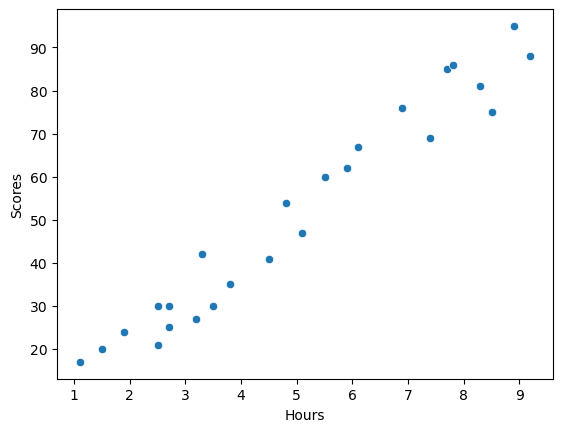

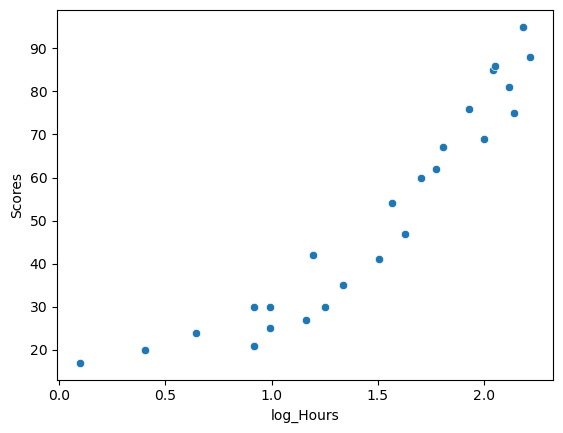

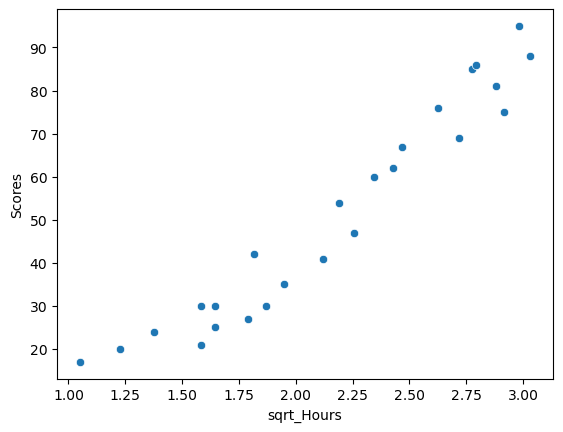

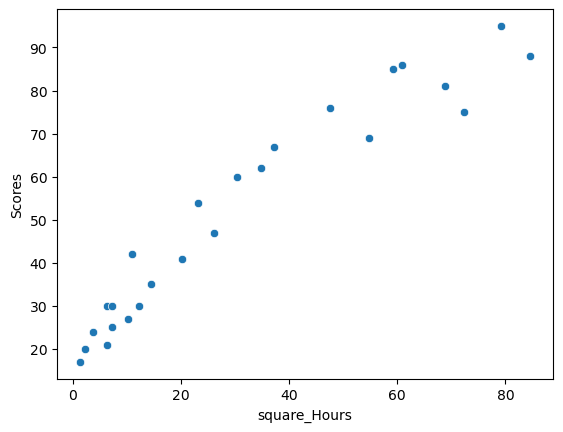

In [80]:
for col in df.drop("Scores",axis=1).columns:
    plt.figure()
    sns.scatterplot(data=df,x=col,y="Scores")

### Define the model

First of all we split data between train data and validation data

We will use the original dataset and the second one with feature engineering

In [38]:
from sklearn.model_selection import train_test_split

# Case with the original dataset
X=df.drop('Scores',axis=1)
y=df.Scores
x_train,x_valid,y_train,y_valid=train_test_split(X,y,train_size=0.8,random_state=0)

# Case with the second dataset
X2=df2.drop('Scores',axis=1)
y2=df2.Scores
x_train2,x_valid2,y_train2,y_valid2=train_test_split(X2,y2,train_size=0.8,random_state=0)

- Importation of labraries 
- Definition of model

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

In [28]:
model=Pipeline(steps=[
    ("scaler",StandardScaler()),
    ("model",LinearRegression())
                     ])

In [47]:
model.fit(x_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

### Define the metrics we will use

In [31]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

def error(y_true,y_pred):
    print(f"Mean squared error : {mean_squared_error(y_true,y_pred)} ")
    print(f"Mean absolute error: {mean_absolute_error(y_true,y_pred)} ")

- Evaluation of models 

In [39]:
# First we fit the model

model.fit(x_train2,y_train2)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [33]:
error(y_train,model.predict(x_train))

Mean squared error : 23.532884486470472 
Mean absolute error: 3.8377165979705468 


In [34]:
model.score(x_train,y_train)

0.9630999972771819

In [35]:
error(y_valid,model.predict(x_valid))

Mean squared error : 28.42869379354247 
Mean absolute error: 4.191378108243008 


In [41]:
error(y_train2,model.predict(x_train2))

Mean squared error : 30.898182377314505 
Mean absolute error: 5.186601709180367 


### Permutation importance to show features with highest importance

In [48]:
import eli5

from eli5.sklearn import PermutationImportance
perm=PermutationImportance(model,random_state=1).fit(x_valid,y_valid)

eli5.show_weights(perm,feature_names=x_valid.columns.tolist())

Weight,Feature
2147.0347 ± 2807.6128,sqrt_Hours
1612.4917 ± 1300.9430,Hours
270.6311 ± 239.8573,log_Hours
86.2818 ± 38.3392,square_Hours


### Plot Partial dependance to show how features affect predictions

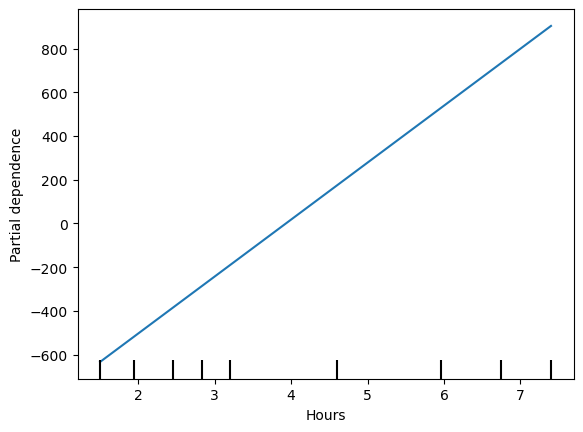

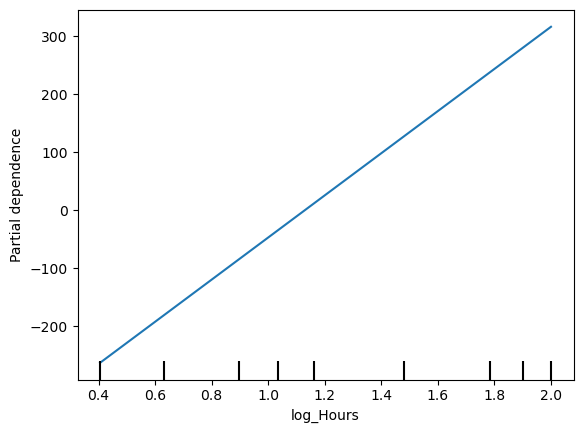

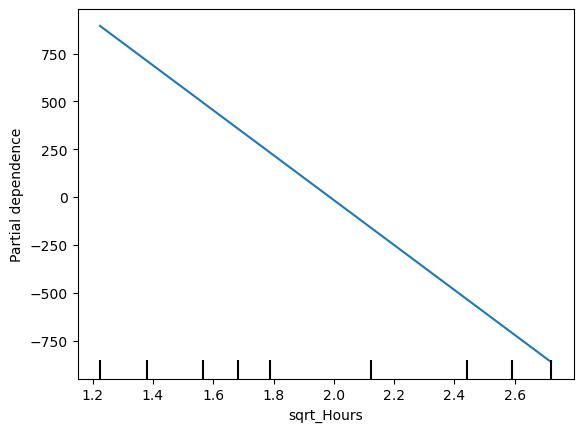

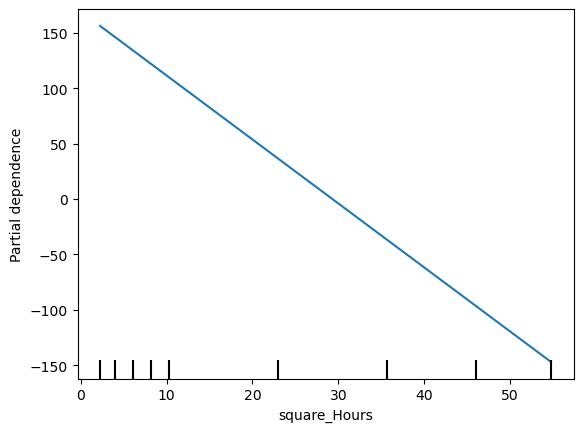

In [52]:
from sklearn.inspection import PartialDependenceDisplay

# Create and plot the data
for col in x_valid.columns:
    disp1 = PartialDependenceDisplay.from_estimator(model, x_valid, [col])
    plt.show()

### Plot the predictions 

<Axes: xlabel='Hours', ylabel='Scores'>

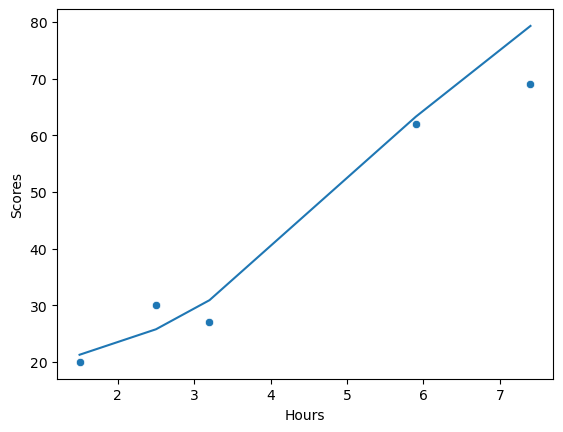

In [62]:
sns.scatterplot(data=x_valid,x="Hours",y=y_valid)
sns.lineplot(data=x_valid,x="Hours",y=model.predict(x_valid))

### Define the final model

- Given that "Hours" and "sqrt_Hours" have high impact on data
- We will define our model using only these ones

<Axes: xlabel='Hours', ylabel='Scores'>

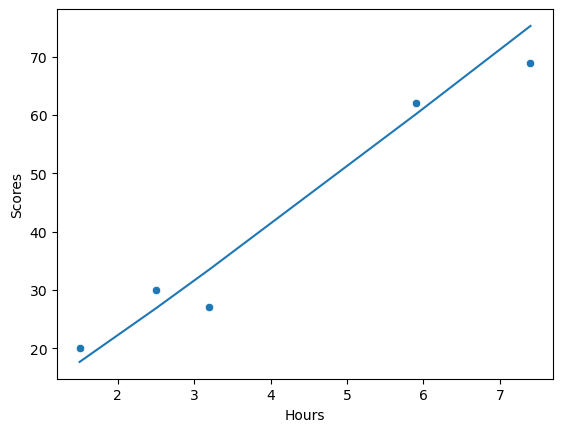

In [66]:
# We only use "Hours","sqrt_Hours" as predictors
df3=df[["Hours","sqrt_Hours","Scores"]]
X3=df3.drop('Scores',axis=1)
y3=df3.Scores

# We split the data
x_train3,x_valid3,y_train3,y_valid3=train_test_split(X3,y3,train_size=0.8,random_state=0)
model3=model
model3.fit(x_train3,y_train3)

sns.scatterplot(data=x_valid3,x="Hours",y=y_valid3)
sns.lineplot(data=x_valid3,x="Hours",y=model3.predict(x_valid3))

- This model seems better than the first one

- Evaluation of the model

In [67]:
error(y_valid3,model3.predict(x_valid3))

Mean squared error : 20.236865063023263 
Mean absolute error: 4.038771320904415 


### Predictions

In [79]:
t=9.25
data=[[t,np.sqrt(t)]]
row=pd.DataFrame(data=data,columns=X3.columns)
model3.predict(row)[0]

94.19634161163117

### Conclusion

 - The prediction was made using the third model
 - The result is: 94.20